## PARAMETERS
* number of customers for each class (ENV)
* conversion rate for each class (item 1) (ENV)
* Second item can be promoted: p0,p1,p2,p3,p4
* Conversion rate item 2 (ENV)
* promos will affect the conversion rates
* prices

In [2]:
import numpy as np
import statistics
from scipy.stats import truncnorm
from scipy.optimize import linear_sum_assignment
import random
import itertools
import matplotlib.pyplot as plt

def clamp(num, min_val, max_val):
	return max(min(num, max_val), min_val)

def generate_conversion_rate(prices):
	val = np.random.rand(len(prices))
	conversion_rates = np.sort(val)[::-1]
	return conversion_rates

def index(array, value):
	return np.where(array == value)[0][0]

In [3]:
class Environment():
    def __init__(self, prices1, prices2, discounts):
        #Shop related data
        self.prices1, self.prices2, self.discounts = prices1, prices2, discounts

        #Customers that will visit the shop during the day
        self.generate_next_day_customers()
        self.n_classes = len(self.customers)
        
        #Conversion rates
        self.true_conv1 = np.array([generate_conversion_rate(prices1) for x in range(self.n_classes)]) # [class x price]
        self.true_conv2 = np.array([[generate_conversion_rate(prices2) for x in range(self.n_classes)] for y in range(len(discounts))]) # [class x promo x price]      
    
    def round1(self, cust_class, price):
        return np.random.binomial(1, self.true_conv1[cust_class, index(self.prices1, price)])
    
    def round2(self, cust_class, promo, price):
        return np.random.binomial(1, self.true_conv2[cust_class, promo, index(self.prices2, price)])

    #Adjust "means" and "variances" in order to test different distributions of customers 
    def generate_next_day_customers(self, means = ([25, 25, 25, 25]), variances =  ([10,10,10,10])):
        means = np.array(means)
        variances = np.array(variances)
        self.customers = np.array([clamp(int(np.random.normal(m, v)), int(m/2), int(3*m/2)) for m,v in zip(means, variances)])


In [4]:
class Shop():
    def __init__(self):
        self.n_classes = 4
        self.prices1 = np.cumsum(np.linspace(80,240, num=5))
        self.prices2 = np.cumsum(np.linspace(100,300, num=5))
        self.discounts = np.array([0.0, 0.05, 0.10, 0.25])
        self.conv1 = np.array([generate_conversion_rate(self.prices1) for x in range(self.n_classes)]) # [class x price]
        self.conv2 = np.array([[generate_conversion_rate(self.prices2) for x in range(self.n_classes)] for y in range(len(self.discounts))]) # [class x promo x price]      
    
    def set_expected_customers(self, customers):
        self.customers = customers
    
    def set_conv_rate(self, conv1, conv2):
        self.conv1 = conv1
        self.conv2 = conv2
    
    def best_promo_per_class(self):
        N = np.array([1,1,1,1])
        weights = np.zeros((4,4))
        perm_prices = list(itertools.product(self.prices1, self.prices2))

        reward = 0

        # for each price
        for p in perm_prices:
            # for each class 
            for c in range(self.n_classes):
                # for each promos
                for j in range(len(self.discounts)):
                    weights[c,j] = p[0]*self.conv1[c, index(self.prices1, p[0])] + (1-self.discounts[j])*p[1]*self.conv2[c,j,index(self.prices2, p[1])]

            col_ind = [np.argmax(row_class) for row_class in weights]
            row_ind = list(range(self.n_classes))
            promo_reward = weights[row_ind,col_ind]
            total_reward = np.sum(promo_reward)

            #print(weights)
            #print(col_ind)
            #print(promo_reward)
            #print(total_reward)
            if (total_reward > reward):
                self.best_price, self.matched_promos, self.promo_rewards, reward = p, col_ind, promo_reward,  total_reward
        #print("=============== \n")
        #print(self.best_price)
        #print(self.matched_promos) # Columns of the weight matrix
    
    def print_coupons(self):
        enum_customers = list(enumerate(self.customers)) # [10, 23, 30, 54] --> [(0, 10), (1, 23), (2, 30), (3, 54)]
        enum_customers = [(self.matched_promos[i], cust) for i, cust in enum_customers] # [(0, 10), (1, 23), (2, 30), (3, 54)] --> [(3, 10), (1, 23), (2, 30), (0, 54)]
        self.coupons = np.concatenate([np.ones(c)*self.discounts[p] for p,c in enum_customers]) # [(3, 10), (1, 23), (2, 30), (0, 54)] --> [0,0,0,0, ... 0.05,0.05,0.05,0.05 ... ]
        



In [5]:

shop = Shop()
env = Environment(shop.prices1, shop.prices2, shop.discounts)

shop.set_conv_rate(env.true_conv1, env.true_conv2)
shop.best_promo_per_class()

T = 20
total_revenue = []
total_clairvoyant = []

for t in range(T):
    env.generate_next_day_customers()
    shop.set_expected_customers(env.customers)

    revenue = []
    clairvoyant = []

    for idx,c in enumerate(shop.customers): # [10,20,30,40] --> [(0,10), (1,20), ...]
        for cust in range(c):
            partial_revenue = 0
            has_bought1 = env.round1(idx, shop.best_price[0])
            partial_revenue = has_bought1*shop.best_price[0]

            if has_bought1 == 1:
                has_bought2 = env.round2(idx, shop.matched_promos[idx], shop.best_price[1])
                partial_revenue += has_bought2*shop.best_price[1]

            revenue.append(partial_revenue)
            expected_revenue = shop.best_price[0]*env.true_conv1[idx, index(env.prices1, shop.best_price[0])] + env.true_conv1[idx, index(env.prices1, shop.best_price[0])]*env.true_conv2[idx, shop.matched_promos[idx], index(env.prices1, shop.best_price[0])]*shop.best_price[1]
            clairvoyant.append(expected_revenue)          
    total_revenue.append([np.mean(revenue)])
    total_clairvoyant.append([np.mean(clairvoyant)])

Text(0, 0.5, 'Revenue')

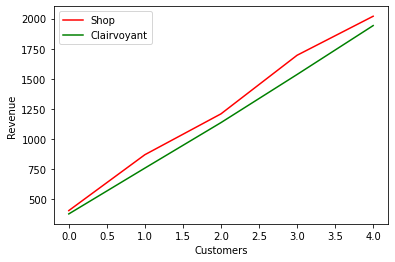

In [6]:
plt.plot(np.cumsum(total_revenue), color='red', label='Shop')
plt.plot(np.cumsum(total_clairvoyant), color='green', label='Clairvoyant')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

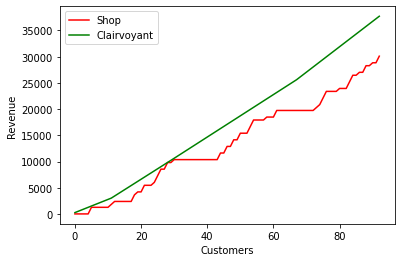

In [9]:
plt.plot(np.cumsum(revenue), color='red', label='Shop')
plt.plot(np.cumsum(clairvoyant), color='green', label='Clairvoyant')

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Revenue')

In [10]:
shop.best_price

(560.0, 700.0)